# 1. An Introduction to Deep Learning for the Physical Layer - Autoncoders knowing gradient of the channel

The goal of this notebook is to implement the autoencoder presented by [O'Shea and Hoydis, 2017](https://arxiv.org/pdf/1702.00832.pdf).

We use pytorch to implement the autoencoder presented in the paper

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import math

# To make the plots
import matplotlib.pyplot as plt
%matplotlib inline

# To supress some strange output at runtime
from IPython.utils import io
# Used during plotting the training loss
from IPython import display

If possible we are going to use GPU to train faster

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Pytorch device: %s' % (device))

Pytorch device: cuda:0


The models implemented in Pytorch and other necessary utilities are loaded from different files. This is done to have a single point of modification and the modules can be used in different places. It also helps us to keep this notebook as clean as possible and focus on the results.

In [3]:
from models import Encoder, Decoder
from utils import plot_constellation, count_errors, MemoryMessages, recover_models
from comms_utils import channel, block_encoder, block_decoder, bler

All the pretrained models are located at this folder. Also if we use this notebook to train a new model is going to be saved at this folder

In [4]:
MODELS_FOLDER = 'trained_models'

This is a flag tha indicates if the notebook should train the models. If the flag is `False` then it is assumed we have some pre-trained models

In [5]:
train = True

### Introduction to Autoencoders

The autoencoder is composed by an Encoder and a Decoder.

The purpose of the Encoder in this case is the same as in communications. It can take up to $M$ possible messasges and find a representation in $n$ possible bits of each message $m$. To transmit $M$ messages we need at least $k = \text{log}_2(M)$ bits. Traditionally this is the notation used in communications to present encoders $(n, k)$, which means $k$ bits encoded into $n$ bits. Traditionally $n \geq k$ to have redundancy bits that can help us in error checking on the reciever side.

The Decoder as the name suggests does the opposite job as the Encoder. It takes $n$ bits and tries to guess the original $m$ message. Normally this is presented as a conditional probability $p(y|x)$ where $y$ is the received message and $x$ the original one.

#### Encoder implementation

The architecture of the Encoder can be summarized as
- Embedding layer or Fully connected layer
- Fully connected layer
- Normalization. Two possbile normalization options

As noted the first layer of the Encoder can variate between an Embedding layer or a Fully connected layer. Depending on the which one we use we need to provide diffrent inputs to the Encoder. In Pytorch the Embedding layer takes the index of a message $m$ and represents it as vector of a specified dimension. In our case we implemented it so the vector has $M$ dimensions. The input of such layer then needs to be a list of messages indexes e.g. `[3, 0, 2, 10, ..]`. If we use a Fully connected layer the input of the Encoder need to be one-hot vectors indicating the messages we want to transmit. Each one-hot encoded vector also has a dimension of $M$. For example if we wanted to transmit message `1` then the one-hot vector would be `[1 0 0 0 0 ... ]`, for message number `3` `[0 0 1 0 0 0 ... ]` and so on. The input of the Encoder would be a list of one-hot encoded vectors.

For the normalization layer we also have two available options. We can use a normalization proposed by the paper or a normalization that already comes in Pytorch. The normalization proposed by the paper is the following
$$
\begin{aligned}
\hat{x} = \frac{\sqrt{N}x}{||x||_2}
\end{aligned}
$$
Where $\hat{x}$ is the normalized vector, $N$ is the dimension of the vector and $x$ is the vector before normalization.
The normalization that Pytorch uses can be found [here](https://pytorch.org/docs/stable/nn.html#batchnorm1d)
When the paper normalization there were some problems realted with gradient explosion. It was decided to use this kind of normalzation in conjunction with clipping the gradients to try to prevent this problem

#### Decoder implementation

The architecture of the Decoder can be summarized as
- Fully connected layer
- Fully connected layer
- LogSoftmax

The LogSoftmax at the end has the purpose to output probabilities. It will output how probable is the $i^{th}$ input of the Decoder beloging to each possible $m$ message. Then we can just take the highest probability to be the response of the Decoder.

In the next cell we implement the training loop. The models can be found in a separate file.

In [6]:
def train_autoencoder(m, n, snr_db=10, chann_type="AWGN", use_embedding=False, use_paper_norm=False,
                     batch_size=32, n_epochs=1000, lr=0.001, clipping=None, plot=None, stop_value=0.005):
    # Trying to avoid exploding gradients by using clipping
    if use_paper_norm:
        assert clipping is not None, "Clipping cannot be none when using paper norm. Might cause errors"
    
    # Get k. Number of bits necessary to transmit the m messages
    k = math.log2(m)
    
    # Initialize the encoder and decoder
    encoder = Encoder(m=m, n=n, use_embedding=use_embedding, use_paper_norm=use_paper_norm)
    encoder.to(device)
    decoder = Decoder(m=m, n=n)
    decoder.to(device)
    
    # Adam optimizer for both encoder and decoder
    enc_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
    dec_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

    # Variables to keep track of losses during training
    losses = []
    avg_losses = []
    errors = []
    avg_errors = []

    for epoch in range(n_epochs):
        # Beginning of the epoch. Fill out the memory
        # Specify to the memory what kind of input we are going to use.
        # Either a list of message indexes (embedding) [0, 3, 10, ..]
        # Or one hot encoded vectors [0 1 0 0.., 0 0 0 1 0 .., ...]
        messages = MemoryMessages(m, use_embedding=use_embedding)
        epoch_errors = 0

        # Until we have something in the memory the epoch has not finished
        while len(messages) > 0:
            # Sample from the memory that is left
            batch, targets_np = messages.sample(batch_size)
            batch_len = len(batch)

            # Make sure the gradients are zero at the beginning
            enc_optimizer.zero_grad()
            dec_optimizer.zero_grad()

            # Transform the sampled data to pytorch tensor
            data = torch.from_numpy(batch).unsqueeze(1).to(device)
            if not use_embedding:
                data = data.type(torch.float).squeeze()

            # Encode the data
            encoded_data = encoder(data)
            # Sometimes during training the weights of the linear layers get NaN when using paper normalization
            # This will cause wrong training. Trying to catch this mistakes
            if torch.isnan(encoded_data).any():
                print("Encoder went to nan. Epoch: %d" % (epoch))

            # Pass the encoded message through the channel
            data_channel = channel(encoded_data, n, k, snr_db, chann_type=chann_type)
            if torch.isnan(data_channel).any():
                print("Channel went to nan. Epoch: %d" % (epoch))

            # Decode the message
            decoded_data = decoder(data_channel)
            if torch.isnan(decoded_data).any():
                print("Decoder went to nan. Epoch: %d" % (epoch))

            # Check if the received labels are the same as the originals
            targets = torch.from_numpy(targets_np).to(device)
            loss = F.nll_loss(decoded_data, targets)

            loss.backward()

            # Get how many classifications mistakes we made
            epoch_errors += count_errors(decoded_data, targets)

            # Trying to avoid NaN in linear layers by clipping the gradients
            if clipping is not None:
                torch.nn.utils.clip_grad_norm_(encoder.parameters(), clipping)
                torch.nn.utils.clip_grad_norm_(decoder.parameters(), clipping)
            
            # Take a SGD step
            enc_optimizer.step()
            dec_optimizer.step()
            
            losses.append(loss.detach().to("cpu").numpy())
            errors.append(epoch_errors/m)
            
            last_losses = np.array(losses[-100:])
            # If the loss is small enough the model has converged. Stop training
            if np.all(last_losses < stop_value):
                return encoder, decoder, errors

        # If we desire to visualize the training we enter this if
        if plot is not None:
            print("Finished epoch: %d. Errors %f. Loss: %f" % (epoch, errors[-1], losses[-1]), end="\r")
            
            if epoch > plot:
                avg = np.mean(losses[-plot:])
                avg_err = np.mean(errors[-plot:])
            else:
                avg = np.mean(losses)
                avg_err = np.mean(errors)
            avg_losses.append(avg)
            avg_errors.append(avg_err)
        
            # Make a plot of training
            if epoch%plot==0 and epoch != 0:
                plt.clf()
                # Unfortunately losses values and classification errors cannot
                # be visualized in the same plot due to scaling issues. Commented out losses plotting
#                 plt.plot(losses, label="Loss")
#                 plt.plot(avg_losses, label="Average loss")
                plt.plot(errors, label="Errors. Supervised training")
                plt.plot(avg_errors, label="Average Errors. Supervised training")
                plt.legend(loc='upper right')
                display.clear_output(wait=True)
                display.display(plt.gcf())
            
            if epoch == n_epochs-1:
                print()
                print("Finished training. Errors %f. Loss: %f" % (errors[-1], losses[-1]))
    
    return encoder, decoder, errors

To see which possible architecture setting reaches better results we are going to try the following:
- Use one-hot encoded vectors and paper normalization. Original paper setting
- Use embeddings and paper normalization
- Use embeddings and Pytorch normalization

These 3 approaches are going to be tried with $M=16, n=7 \text{ and } \text{SNR}_{\text{dB}}=7$. In traiditional communication this would mean an encoder $(n, k) = (7, 4)$. Also for the three approaches we are going to use the same number of epochs in training.

#### One-hot encoded vectors and paper normalization

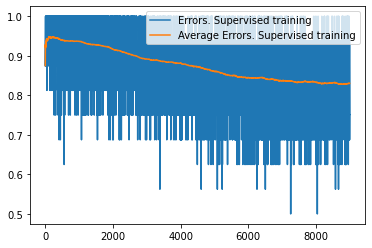

Finished epoch: 9999. Errors 0.937500. Loss: 2.437057
Finished training. Errors 0.937500. Loss: 2.437057


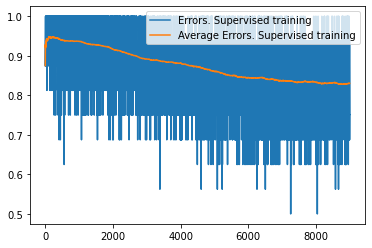

In [7]:
# Sample on how training can be executed with paper normalization without embeddings. Original proposed settings
# Because of clipping and bad normalization a lot of samples to converge
if train:
    _, _, _ = train_autoencoder(m=16, n=7, snr_db=7, n_epochs=10000, use_embedding=False,
                                use_paper_norm=True, clipping=1, plot=1000)

#### Embeddings and paper normalization

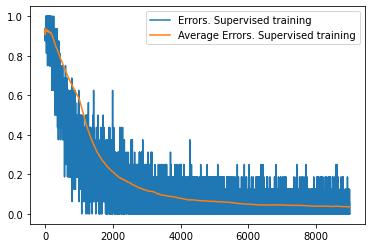

Finished epoch: 9999. Errors 0.000000. Loss: 0.013756
Finished training. Errors 0.000000. Loss: 0.013756


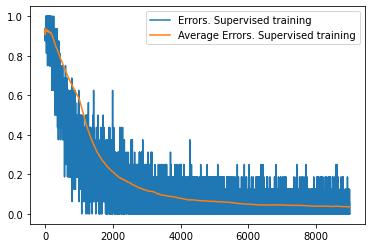

In [8]:
# Sample on how training can be executed with paper normalization and embeddings
if train:
    _, _, _ = train_autoencoder(m=16, n=7, snr_db=7, n_epochs=10000, use_embedding=True,
                                use_paper_norm=True, clipping=0.5, plot=1000)

#### Embeddings and Pytorch normalization

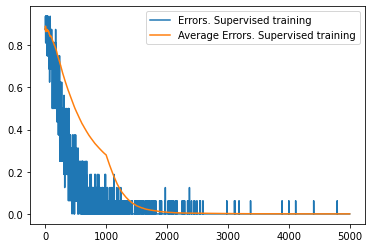

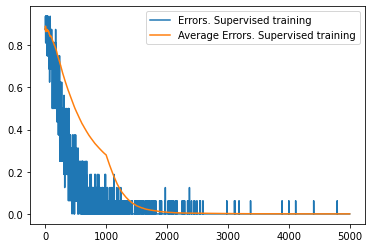

In [9]:
# Sample on how training can be executed using embeddings and pytorch normalization
if train:
    _, _, _ = train_autoencoder(m=16, n=7, snr_db=7, n_epochs=10000, use_embedding=True,
                                use_paper_norm=False, plot=1000)

As we note from the last training plots the approach of using one-hot encoded vectors and the normalization proposed by the paper is the worst one. This probably has to do with the fact that a one-hot encoded vector carries very little information making it hard for the loss to converge. Also some factor that may influence is the need to use clipping with the paper normalization. The classification errors were decreasing but a very little slow rate. The best and fastest performance was achieved using embeddings and Pytorch normalization. From here on we will use this setup to train our models.

In the paper they compare the performance of the Autoencoder with a traditional BPSK and Hamming encoding. The $(n, k)$ encodings used are $(4, 4)\ (7, 4)\ (8, 8)\ (2, 2)$. Next we are going to train our Autoencoder for these settings at a constant $\text{SNR}_{\text{dB}}=7$

In [10]:
# Train over all the (m, n). M messages encoded in n bits. m = 2**k
# Equivalent to (n, k). k bits for messages encoded in n bits. k = log2(m)
hamming_sizes = [(16, 4), (16, 7), (256, 8), (4, 2)]
chann_type = "AWGN"
if train:
    for m, n in hamming_sizes:
        print("Training autoencoder (%d, %d)" % (m, n))
        encoder, decoder, errors = train_autoencoder(m=m, n=n, snr_db=7, n_epochs=10000, chann_type=chann_type,
                                                         use_embedding=True, use_paper_norm=False)

        # Save the encoder and decoder models
        enc_filename = "%s/%s_%d_%d_encoder.pth" % (MODELS_FOLDER, chann_type, m, n)
        dec_filename = "%s/%s_%d_%d_decoder.pth" % (MODELS_FOLDER, chann_type, m, n)
        torch.save(encoder.state_dict(), enc_filename)
        torch.save(decoder.state_dict(), dec_filename)

        print("Models saved in %s, %s" % (enc_filename, dec_filename))

Training autoencoder (16, 4)
Models saved in trained_models/AWGN_16_4_encoder.pth, trained_models/AWGN_16_4_decoder.pth
Training autoencoder (16, 7)
Models saved in trained_models/AWGN_16_7_encoder.pth, trained_models/AWGN_16_7_decoder.pth
Training autoencoder (256, 8)
Models saved in trained_models/AWGN_256_8_encoder.pth, trained_models/AWGN_256_8_decoder.pth
Training autoencoder (4, 2)
Models saved in trained_models/AWGN_4_2_encoder.pth, trained_models/AWGN_4_2_decoder.pth


Now we can watch the constellation generated by our Encoder. This is done by getting the encoding for all possible messages and then adding 20 noise samples. So for every $m$ message of $M$ we will plot 20 different samples with noise. After adding the noise we will visualize the constellation using 2 dimensional t-SNE. If the encoder is trained properly we would be able to clearly distinguish between the groups of noisy samples of each $m$ message.

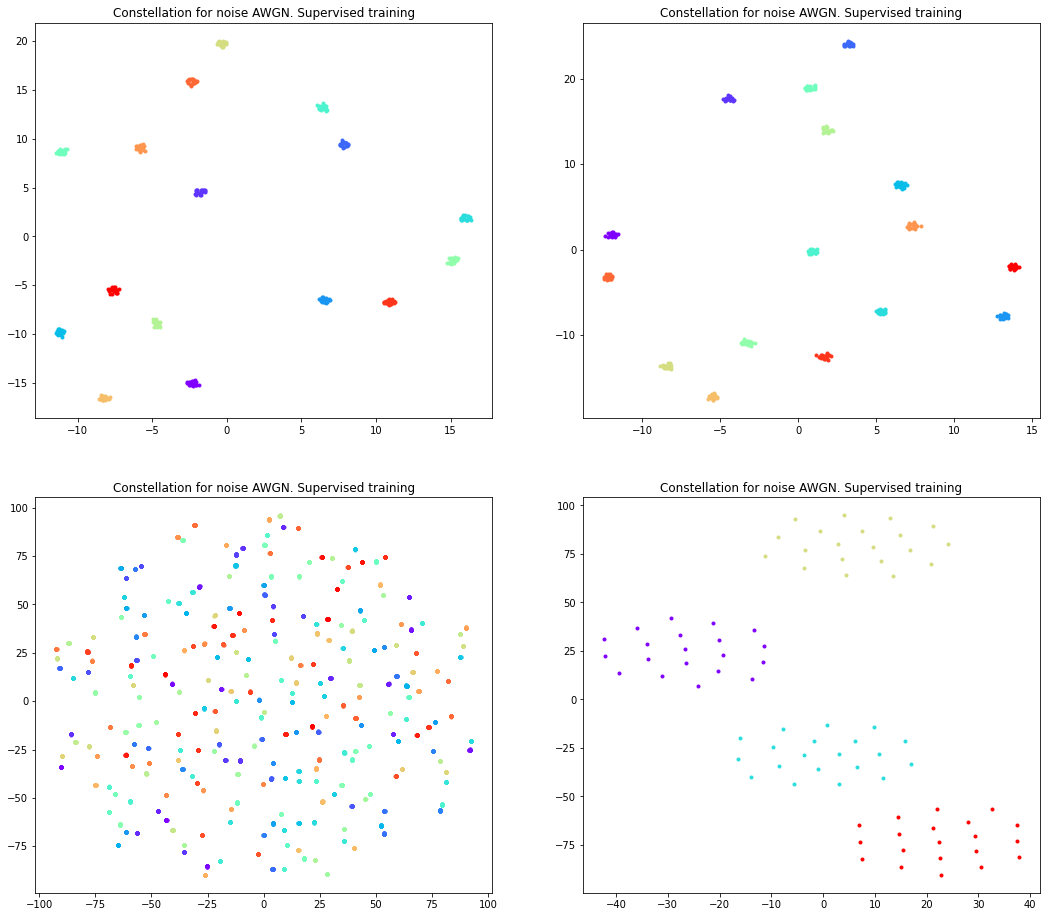

In [11]:
# Plot all (m, n)
hamming_sizes = [(16, 4), (16, 7), (256, 8), (4, 2)]
fig, axs = plt.subplots(2, 2, figsize=(18, 16), facecolor='w')
for i in range(2):
    for j in range(2):
        idx = j + i*2
        m, n = hamming_sizes[idx]
        ax = plot_constellation(m=m, n=n, model="supervised", ax=axs[i, j], device=device)

Now we can simulate end-to-end communication. We use the pre-trained models to encode a block of messages. First the messages will go through the Encoder, then they will go through the channel that will add noise and at the end we will pass them through the Decoder. As mentioned before, the decoder will output the probability the received sample corresponds to each $m$ message. We are going to pick the one with highest probability. After this decission we are going to check how many mistakes we had i.e. calculate the Block Error Rate (BLER).

In [27]:
def nn_communication(m, n, snr_db, n_blocks, chann_type="AWGN",
                     model="supervised", verbose=False):
    # Get the pretrained models
    enc, dec = recover_models(device, model=model, m=m, n=n, chann_type=chann_type)
    
    # Print the parameters of our trained models
    if verbose: print("Models")
    if verbose: print(enc)
    if verbose: print(dec)
    if verbose: print()

    k = math.log2(m)
    
    # We are not training hence not using gradients. Just evaluating
    with torch.no_grad():
        # Generate as much data as specified in the parameters
        data = torch.randint(0, m, (n_blocks, 1)).to(device)
        if verbose: print("Original x")
        if verbose: print(data)
        
        # Encode the data (Tx)
        enc_data = enc(data)
        if verbose: print("Encoded x")
        if verbose: print(enc_data)
    
        # Pass the data through the channel. Add noise
        noise_data = channel(enc_data, n, k, snr_db, chann_type=chann_type)
        if verbose: print("x with noise")
        if verbose: print(noise_data)
        
        # Decode the data (Rx)
        dec_data = dec(noise_data, chann_type=chann_type)
        
        # The last layer returns probabilites over all possible messages
        # Choose the one that has the highest one
        data_dec = torch.argmax(dec_data, dim=1).unsqueeze(1)
        if verbose: print("Recovered x")
        if verbose: print(data_dec)
        
        # Count the errors that we had
        errors = data_dec != data
        total_errors = errors.sum().to("cpu").numpy()

    # Get the error. Rate of the errrors
    bler = total_errors/n_blocks
    if verbose: print("BLER")
    if verbose: print(bler)

    print("Finished calculations for channel (%s). SNR dB: %f." % (chann_type, snr_db))
    return bler

In [28]:
# Visualize a small sample communication
nn_communication(m=16, n=7, snr_db=0, n_blocks=10, model="supervised", chann_type="AWGN", verbose=True)

Models
Encoder(
  (linear_M): Sequential(
    (0): Embedding(16, 16)
    (1): ReLU()
  )
  (linear_N): Sequential(
    (0): Linear(in_features=16, out_features=7, bias=True)
  )
  (normalization): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Decoder(
  (linear_relu): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): ReLU()
  )
  (linear_out): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LogSoftmax()
  )
)

Original x
tensor([[10],
        [15],
        [ 2],
        [14],
        [14],
        [ 3],
        [ 6],
        [ 7],
        [ 7],
        [12]], device='cuda:0')
Encoded x
tensor([[-0.0712, -1.1519, -1.6068,  1.5853,  0.0487,  0.7359,  2.3451],
        [-2.3904,  2.4989, -1.2515, -0.5506,  1.4924, -1.2562, -1.7512],
        [-0.3046, -2.2308,  0.9921, -0.6842, -1.0018,  1.9978, -2.1422],
        [ 1.2614,  1.0663, -0.2769, -0.2517,  1.3665, -2.0499,  0.8068],
        [ 1.2614,

0.2

### Theoretical encoding using BPSK and Hamming

To compare the autoencoder we are going to simluate a traditional communications system using BPSK and Hamming $(n, k)$. First we are going to simulate messages with $k$ bits using `numpy` and then get `n` encoded bits. Encoding is done using Hamming algorithm, the implementation of the Hamming algorithm can be found in Python library [scikit-dsp-comm](https://pypi.org/project/scikit-dsp-comm/). After encoding the bits they are modulated using BPSK. BPSK can be simulated by just transforming the inputs with values between 0 and 1 to values between -1 and 1. Once modulated we can pass them through the channel adding AWGN. On the receiver side we first de-modulate the bits i.e. pass now from -1 to 1 values to 0 and 1 and then decode them using Hamming. As a final step we check how many mistakes we had and return the BLER.

All the implementation of the functions used in the end-to-end communication can be found in a separate file. Here we are just going to visualize some simple example and use the modules.

*Note:* The implementation of BPSK is based on the example presented [here]((https://scipy-cookbook.readthedocs.io/items/CommTheory.html))

In [22]:
def bpsk_communication(m, n, snr_db, n_blocks, chann_type=chann_type, verbose=False):
    # Get k. Number of bits necessary to transmit the m messages
    k = int(math.log2(m))

    # Generate inputs
    x = np.random.randint(0, 2, size=(n_blocks, k))
    if verbose: print("Original x")
    if verbose: print(x)
    
    # Encode the messages using Hamming
    # Strange output from library sk_dsp_comm.fec_block when doing hamming coding
    # e.g. (7,4) hamming code object
    # Supressing such output with this line
    with io.capture_output() as captured:
        x_encoded = block_encoder(x, n, k)
    if verbose: print("Encoded x")
    if verbose: print(x_encoded)
    
    # Signal vector to transmit (modulation)
    s_transmit = 2*x_encoded - 1
    if verbose: print("Modulated x")
    if verbose: print(s_transmit)
    
    # Add the noise
    s_noise = channel(s_transmit, n, k, snr_db, chann_type=chann_type)
    if verbose: print("x with noise after channel")
    if verbose: print(s_noise)
    
    # Demoludation of the signal
    y = np.sign(s_noise)
    y_enc = (y + 1)/2
    
    if verbose: print("Demodulated received x")
    if verbose: print(y_enc.astype(int))

    # Decode them using Hamming
    with io.capture_output() as captured:
        x_rec = block_decoder(y_enc.astype(int), n, k)
    
    if verbose: print("Decoded x")
    if verbose: print(x_rec)

    # Get the bler
    block_bler = bler(x, x_rec)
    if verbose: print("BLER")
    if verbose: print(block_bler)
    
    print("Finished calculations for BPSK(%d, %d) channel: %s. SNR dB: %f." % (n, k, chann_type, snr_db))

    return block_bler

In [23]:
# Visualize BPSK communication
bpsk_communication(m=16, n=7, snr_db=0, chann_type="AWGN", n_blocks=10, verbose=True)

Original x
[[0 0 1 1]
 [1 1 1 1]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 1 0]
 [1 0 1 1]
 [0 1 0 0]
 [0 0 1 1]
 [0 1 0 1]
 [0 0 0 1]]
Encoded x
[[0 0 1 1 1 1 0]
 [1 1 1 1 1 1 1]
 [0 0 0 1 1 0 1]
 [0 1 0 0 1 1 0]
 [0 0 1 0 0 1 1]
 [1 0 1 1 0 0 1]
 [0 1 0 0 1 1 0]
 [0 0 1 1 1 1 0]
 [0 1 0 1 0 1 1]
 [0 0 0 1 1 0 1]]
Modulated x
[[-1 -1  1  1  1  1 -1]
 [ 1  1  1  1  1  1  1]
 [-1 -1 -1  1  1 -1  1]
 [-1  1 -1 -1  1  1 -1]
 [-1 -1  1 -1 -1  1  1]
 [ 1 -1  1  1 -1 -1  1]
 [-1  1 -1 -1  1  1 -1]
 [-1 -1  1  1  1  1 -1]
 [-1  1 -1  1 -1  1  1]
 [-1 -1 -1  1  1 -1  1]]
x with noise after channel
[[-2.0745477  -1.65505676  0.01771164  0.68137403  1.66593433  1.68519541
  -2.01316337]
 [ 0.93600727  1.34137511  3.28251465  0.66898241  1.65878922  0.06728508
   0.57469907]
 [ 0.18670636 -0.52175147  1.69005803  1.05402537  1.71060687 -2.44854884
   1.13566302]
 [-1.31521709  2.06544752 -2.12839814 -0.10282916 -0.18837879  2.97226335
   0.080063  ]
 [-1.93327931 -0.74984327  0.82350028  0.33673695  0.40973719

0.3

## Results

We will go through all the $(n, k)$ encodings with which we trained our Autoencoder $(4, 4)\ (7, 4)\ (8, 8)\ (2, 2)$. The Autoencoders were trained at a constant $\text{SNR}_{\text{dB}}=7$ and we are going to put them through noise levels between -4 and 10. We are going to compare the BLER obtained at each noise level with the theoretical BPSK simmulation.

In [39]:
# Defining the hamming encoding sizes (m, n)
hamming_sizes = [(16, 4), (16, 7), (256, 8), (4, 2)]

# Defining all noise levels
snrs_db = np.arange(-4, 10, 1)

# Number of input messages to simulate
n_blocks = 250000

# To store the resutls
results_y = np.zeros((2, len(hamming_sizes), len(snrs_db)))

# Iterate over all the (m, n) encodings
for hamm_n, (m, n) in enumerate(hamming_sizes):
    # Iterate over the noise levels
    for snr_n, snr_db in enumerate(snrs_db):
        # Get the bler using theoritcal encoding
        bler_bpsk = bpsk_communication(m=m, n=n, snr_db=snr_db, n_blocks=n_blocks, chann_type="AWGN")
        
        # Get the bler using autoencoder
        bler_autoenc = nn_communication(m=m, n=n, snr_db=snr_db, n_blocks=n_blocks,
                                        chann_type="AWGN", model="supervised")
        
        # Store the results
        results_y[0, hamm_n, snr_n] = bler_bpsk
        results_y[1, hamm_n, snr_n] = bler_autoenc
        
        torch.cuda.empty_cache()

Finished calculations for BPSK(4, 4) channel: AWGN. SNR dB: -4.000000.
Finished calculations for channel (AWGN). SNR dB: -4.000000.
Finished calculations for BPSK(4, 4) channel: AWGN. SNR dB: -3.000000.
Finished calculations for channel (AWGN). SNR dB: -3.000000.
Finished calculations for BPSK(4, 4) channel: AWGN. SNR dB: -2.000000.
Finished calculations for channel (AWGN). SNR dB: -2.000000.
Finished calculations for BPSK(4, 4) channel: AWGN. SNR dB: -1.000000.
Finished calculations for channel (AWGN). SNR dB: -1.000000.
Finished calculations for BPSK(4, 4) channel: AWGN. SNR dB: 0.000000.
Finished calculations for channel (AWGN). SNR dB: 0.000000.
Finished calculations for BPSK(4, 4) channel: AWGN. SNR dB: 1.000000.
Finished calculations for channel (AWGN). SNR dB: 1.000000.
Finished calculations for BPSK(4, 4) channel: AWGN. SNR dB: 2.000000.
Finished calculations for channel (AWGN). SNR dB: 2.000000.
Finished calculations for BPSK(4, 4) channel: AWGN. SNR dB: 3.000000.
Finished cal

Comparing the results. Each Autoencoder with the correspondent BPSK simulation.

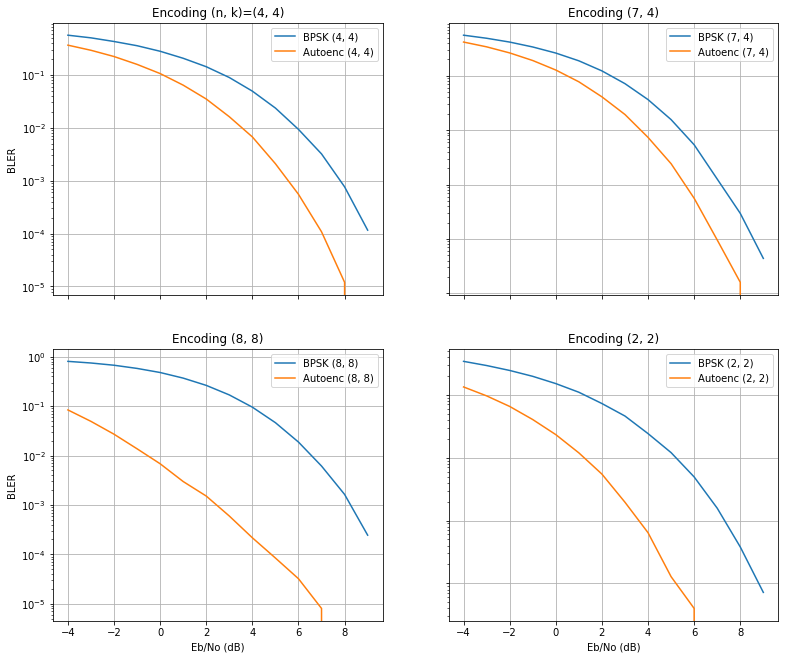

In [40]:
# Comparing each autoencoder with the theoritcal result
fig, axs = plt.subplots(2, 2, figsize=(13, 11), facecolor='w')

axs[0, 0].semilogy(snrs_db, results_y[0, 0,:], label='BPSK (4, 4)')
axs[0, 0].semilogy(snrs_db, results_y[1, 0,:], label='Autoenc (4, 4)')
axs[0, 0].legend(loc='upper right')
axs[0, 0].set_title('Encoding (n, k)=(4, 4)')

axs[0, 1].semilogy(snrs_db, results_y[0, 1,:], label='BPSK (7, 4)')
axs[0, 1].semilogy(snrs_db, results_y[1, 1,:], label='Autoenc (7, 4)')
axs[0, 1].legend(loc='upper right')
axs[0, 1].set_title('Encoding (7, 4)')

axs[1, 0].semilogy(snrs_db, results_y[0, 2,:], label='BPSK (8, 8)')
axs[1, 0].semilogy(snrs_db, results_y[1, 2,:], label='Autoenc (8, 8)')
axs[1, 0].legend(loc='upper right')
axs[1, 0].set_title('Encoding (8, 8)')

axs[1, 1].semilogy(snrs_db, results_y[0, 3,:], label='BPSK (2, 2)')
axs[1, 1].semilogy(snrs_db, results_y[1, 3,:], label='Autoenc (2, 2)')
axs[1, 1].legend(loc='upper right')
axs[1, 1].set_title('Encoding (2, 2)')

for ax in axs.flat:
    ax.grid(True)
    ax.set(xlabel='Eb/No (dB)', ylabel='BLER')

for ax in axs.flat:
    ax.label_outer()

To my surprise they are not the same. We got better results, at every single $(n, k)$ the Autoencoder outperforms BPSK. This can be due to the fact that the normalization used was different than the one presented in the paper. One other thing that could affect is the implementation of embedding in Pytorch and Tensorflow (the paper used Tensorflow). Also I did not have time to check and compare the results obtained from the BPSK simmulation to other resilts from more specialized software like *Matlab*, it could be interesting to know if the results obtained here are similar.

The following plots are the ones presented in the original paper. 

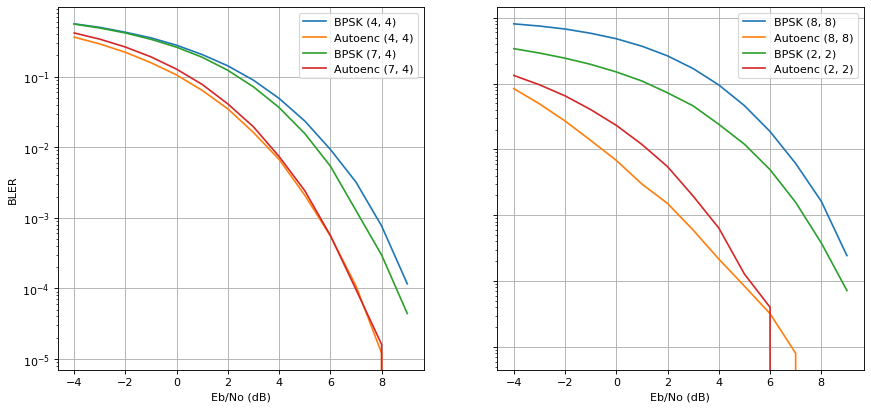

In [41]:
# Comparing each autoencoder with the theoritcal result
fig, axs = plt.subplots(1, 2, figsize=(13, 6), dpi= 80, facecolor='w')

axs[0].semilogy(snrs_db, results_y[0, 0,:], label='BPSK (4, 4)')
axs[0].semilogy(snrs_db, results_y[1, 0,:], label='Autoenc (4, 4)')
axs[0].semilogy(snrs_db, results_y[0, 1,:], label='BPSK (7, 4)')
axs[0].semilogy(snrs_db, results_y[1, 1,:], label='Autoenc (7, 4)')
axs[0].legend(loc='upper right')

axs[1].semilogy(snrs_db, results_y[0, 2,:], label='BPSK (8, 8)')
axs[1].semilogy(snrs_db, results_y[1, 2,:], label='Autoenc (8, 8)')
axs[1].semilogy(snrs_db, results_y[0, 3,:], label='BPSK (2, 2)')
axs[1].semilogy(snrs_db, results_y[1, 3,:], label='Autoenc (2, 2)')
axs[1].legend(loc='upper right')

for ax in axs.flat:
    ax.grid(True)
    ax.set(xlabel='Eb/No (dB)', ylabel='BLER')

for ax in axs.flat:
    ax.label_outer()